In [1]:
# To Do:
# experiment with other MONAI classifiers
# change the mask dimension to the output of the segmentation model
# see if theres a better way to use the segmentation map in the model
# hand crafted features e.g. bounding box fuzziness, width of mask, convex hull difference from mask to work out border irregularity etc
# add augmentation 
# patch based training

In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as F2
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from collections import Counter
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve
from monai.networks.nets import DenseNet169 #, HighResNet, EfficientNet, ResNet


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_DIR = r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\Mycetoma Dataset"

# Get the paths
train_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*')])
val_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*')])
# post processing binary 
# train_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/binary postprocessed/corrected_masks_and_augmented_postproc_training/**/*')])
# val_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/binary postprocessed/corrected_masks_and_augmented_postproc_validation/**/*')])
# logits 
# train_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/logit output/corrected_masks_and_augmented_training/**/*')])
# val_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/logit output/corrected_masks_and_augmented_validation/**/*')])

# multitask binary
train_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/binary postprocessed/multitask_postproc_training/**/*')])
val_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/binary postprocessed/multitask_postproc_validation/**/*')])

# multitask logit
# train_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/logit output/multitask_training/**/*')])
# val_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/logit output/multitask_validation/**/*')])

# remove any with mask in it
train_img_paths = train_paths[[not 'mask' in i for i in train_paths]]
val_img_paths = val_paths[[not 'mask' in i for i in val_paths]]

def format_file_paths(paths, img_paths):
    file_paths = []
    patient = []
    for file in img_paths:
        patient.append(file)
        matched = False
        #file_start = '.'.join(file.split('.')[:-1])
        file_end = file.split("\\")[-1].split('.')[0]
        for file2 in paths:
            if 'mask' in file2:
                #file_start2 = '.'.join(file2.split('.')[:-1])[:-5]
                file_end2 = '_'.join(file2.split("\\")[-1].split('.')[0].split('_')[0:2])
                if file_end == file_end2:
                    patient.append(file2)
                    file_paths.append(patient)
                    patient = []
                    matched = True
        if matched == False:
            print(f"Could not find mask for {file_end}")
    return file_paths

train_paths = format_file_paths(train_seg_paths, train_img_paths)
val_paths = format_file_paths(val_seg_paths, val_img_paths)



print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")


def clip_and_norm(image, upper_bound):
    # Clip intensity values
    image = np.clip(image, 0, upper_bound)

    # Normalize the image to the range [0, 1]
    norm = (image - 0) / (upper_bound - 0)

    return norm

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# MAKE DATASET CLASS

# Define the 3D Dataset class
# Image and mask both need same transforms to be applied, so DO NOT USE RANDOM TRANSFORMS
# - use e.g. transforms.functional.hflip which has no randomness.
class MycetomaDataset(Dataset):
    def __init__(self, paths, data_dir, transform=None, transform_chance=0.5):
        self.paths = paths
        self.data_dir = data_dir
        self.transform = transform
        self.transform_chance = transform_chance

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image_path = self.paths[index][0]
        mask_path = self.paths[index][1]

        # Load the image and mask
        image = np.asarray(Image.open(image_path))
        mask = np.asarray(Image.open(mask_path))
        if 'BM' in image_path:
            label = 0
        if 'FM' in image_path:
            label = 1

        # Check image and mask size
        assert image.shape == (600, 800, 3), "Image size must be (600, 800, 3)"

        # if mask more than one channel, turn to 2d by taking first channel
        if len(mask.shape) > 2:
            mask = mask[..., 0]

        # normalise image
        image = clip_and_norm(image, 255)
        

        # clip mask
        # assert mask.max() == 1, "Mask must be binary"

        # turn to torch, permute image to move channel to front, and return
        image = torch.from_numpy(image).float().permute(2,0,1)
        mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        if self.transform != None:
            transform1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
            ])
            transform2 = transforms.Compose([
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)
            ])
            
            image, mask = transform1(image, mask)
            image = transform2(image)
                
        image = torch.cat((image, mask), dim=0)

        return image, label

In [3]:
train_dataset = MycetomaDataset(train_paths, DATA_DIR, transform=True)
test_dataset = MycetomaDataset(val_paths, DATA_DIR)
# MAKE DATALOADER
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [4]:
# visualise transformed images
for i in range(5):
    image, label = train_dataset[i]
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)
        ])
    image2 = transform(image)
    # show image 1 and 2 side by side
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.permute(1,2,0))
    ax[0].set_title('Original')
    ax[1].imshow(image2.permute(1,2,0))
    ax[1].set_title('Transformed')
    plt.show()

C:\Users\mm17b2k.DS\AppData\Local\Temp\ipykernel_17280\3697484248.py:44: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  mask = torch.from_numpy(mask).float().unsqueeze(0)


TypeError: Input image tensor permitted channel values are 1 or 3, but found 4

Learning rate: 5e-05
Epoch [1/50], Train Loss: 0.5974, Train Accuracy: 0.6965, Train AUC: 0.6933, Sensitivity: 0.7588, Specificity: 0.6277 MCC: 0.3905
Train Confusion Matrix:
[[177 105]
 [ 75 236]]
Test Loss: 0.7782, Test Accuracy: 0.6264, Test AUC: 0.6122 Sensitivity: 0.6981, Specificity: 0.5263 MCC: 0.2263
Test Confusion Matrix:
[[20 18]
 [16 37]]


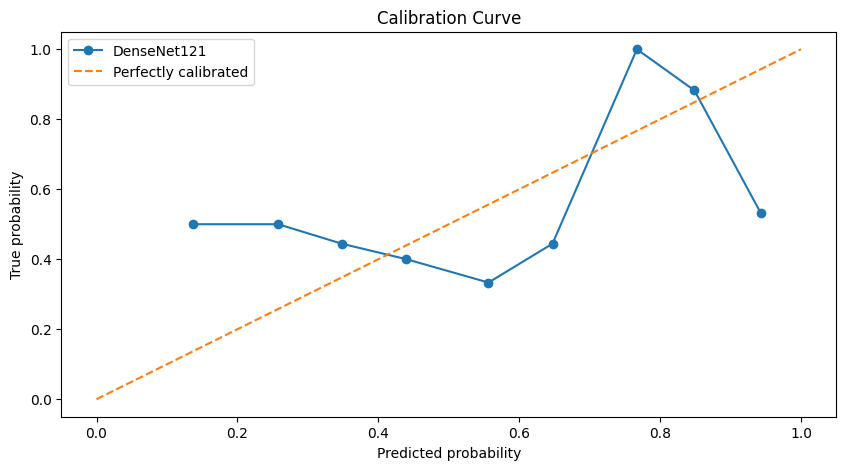

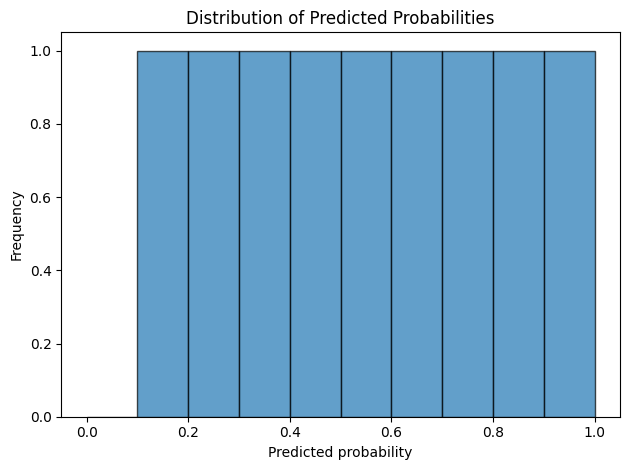

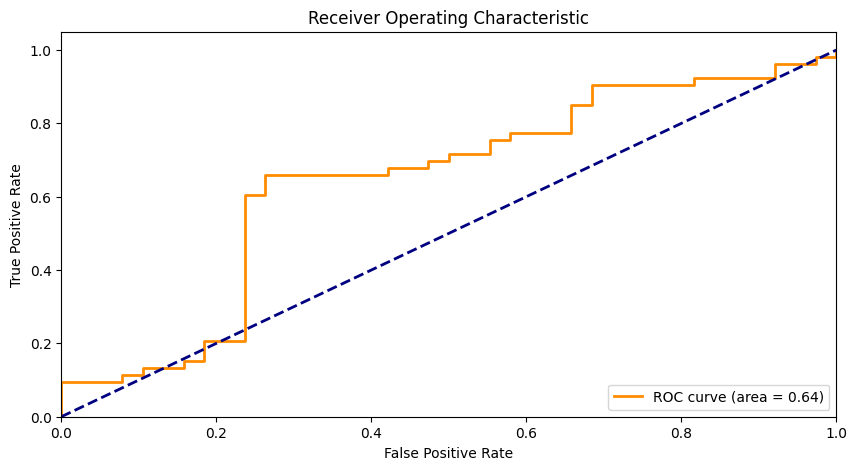

Learning rate: 5e-05
Epoch [2/50], Train Loss: 0.4478, Train Accuracy: 0.8027, Train AUC: 0.8054, Sensitivity: 0.7492, Specificity: 0.8617 MCC: 0.6123
Train Confusion Matrix:
[[243  39]
 [ 78 233]]
Test Loss: 0.6187, Test Accuracy: 0.7363, Test AUC: 0.7401 Sensitivity: 0.7170, Specificity: 0.7632 MCC: 0.4738
Test Confusion Matrix:
[[29  9]
 [15 38]]
Learning rate: 5e-05
Epoch [3/50], Train Loss: 0.3015, Train Accuracy: 0.8803, Train AUC: 0.8806, Sensitivity: 0.8746, Specificity: 0.8865 MCC: 0.7605
Train Confusion Matrix:
[[250  32]
 [ 39 272]]
Test Loss: 0.4153, Test Accuracy: 0.8242, Test AUC: 0.8416 Sensitivity: 0.7358, Specificity: 0.9474 MCC: 0.6772
Test Confusion Matrix:
[[36  2]
 [14 39]]
Learning rate: 5e-05
Epoch [4/50], Train Loss: 0.2654, Train Accuracy: 0.8971, Train AUC: 0.8973, Sensitivity: 0.8939, Specificity: 0.9007 MCC: 0.7941
Train Confusion Matrix:
[[254  28]
 [ 33 278]]
Test Loss: 0.3479, Test Accuracy: 0.8791, Test AUC: 0.8925 Sensitivity: 0.8113, Specificity: 0.973

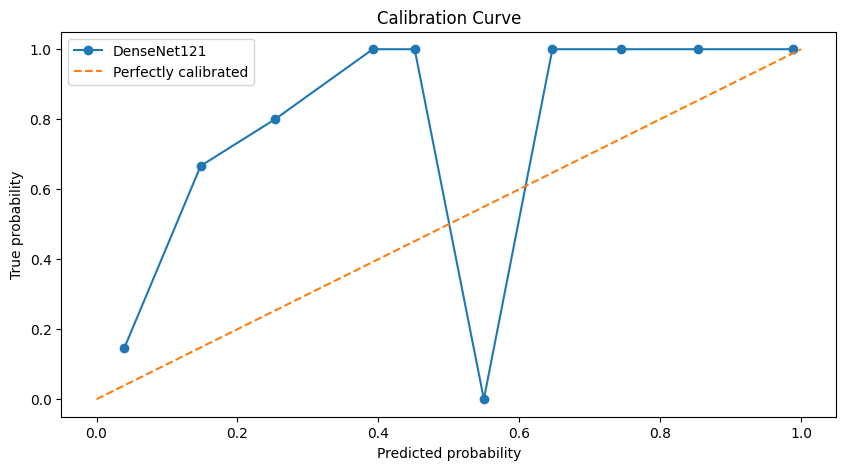

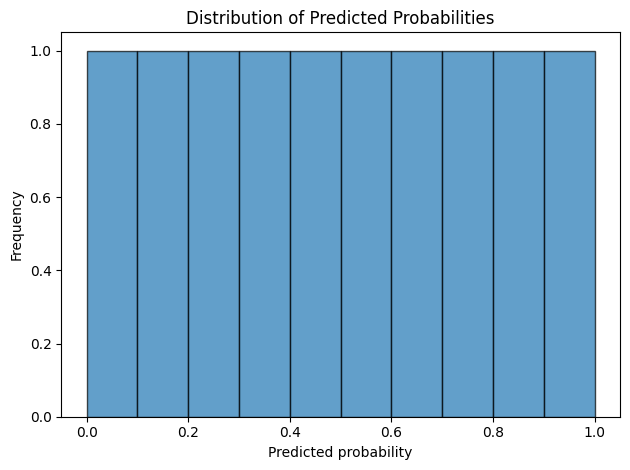

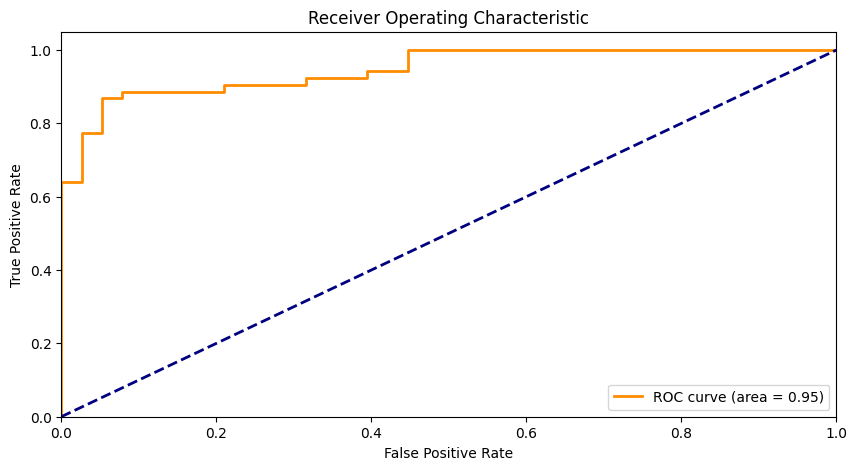

Learning rate: 5e-05
Epoch [7/50], Train Loss: 0.1623, Train Accuracy: 0.9393, Train AUC: 0.9391, Sensitivity: 0.9421, Specificity: 0.9362 MCC: 0.8783
Train Confusion Matrix:
[[264  18]
 [ 18 293]]
Test Loss: 0.4887, Test Accuracy: 0.7473, Test AUC: 0.7197 Sensitivity: 0.8868, Specificity: 0.5526 MCC: 0.4744
Test Confusion Matrix:
[[21 17]
 [ 6 47]]
Learning rate: 5e-05
Epoch [8/50], Train Loss: 0.1122, Train Accuracy: 0.9730, Train AUC: 0.9730, Sensitivity: 0.9743, Specificity: 0.9716 MCC: 0.9459
Train Confusion Matrix:
[[274   8]
 [  8 303]]
Test Loss: 0.2649, Test Accuracy: 0.8901, Test AUC: 0.8833 Sensitivity: 0.9245, Specificity: 0.8421 MCC: 0.7732
Test Confusion Matrix:
[[32  6]
 [ 4 49]]
Learning rate: 5e-05
Epoch [9/50], Train Loss: 0.1108, Train Accuracy: 0.9663, Train AUC: 0.9664, Sensitivity: 0.9646, Specificity: 0.9681 MCC: 0.9324
Train Confusion Matrix:
[[273   9]
 [ 11 300]]
Test Loss: 0.2943, Test Accuracy: 0.8901, Test AUC: 0.8945 Sensitivity: 0.8679, Specificity: 0.921

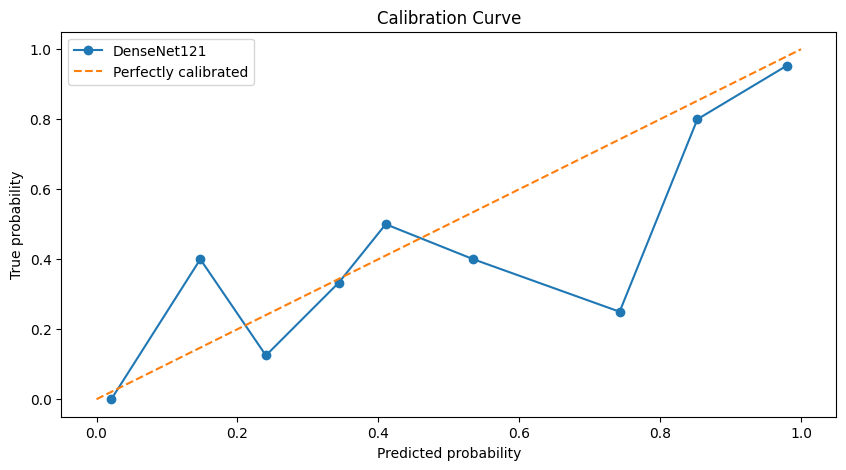

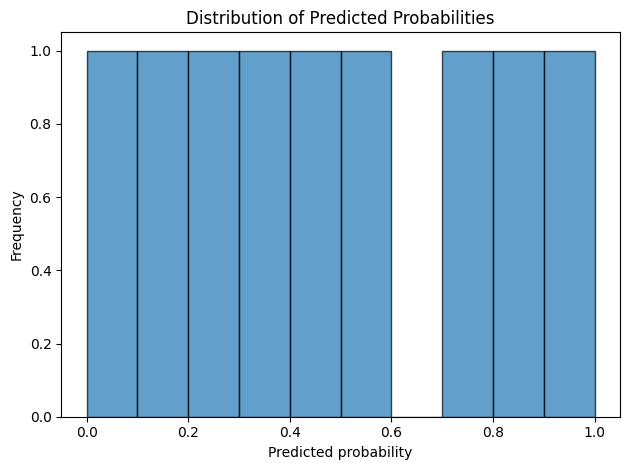

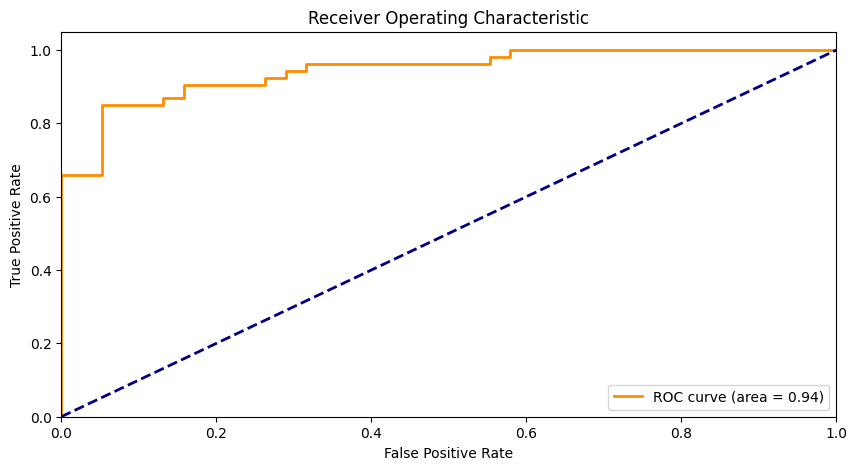

Learning rate: 5e-05
Epoch [27/50], Train Loss: 0.0206, Train Accuracy: 0.9983, Train AUC: 0.9984, Sensitivity: 0.9968, Specificity: 1.0000 MCC: 0.9966
Train Confusion Matrix:
[[282   0]
 [  1 310]]
Test Loss: 0.4351, Test Accuracy: 0.8901, Test AUC: 0.8982 Sensitivity: 0.8491, Specificity: 0.9474 MCC: 0.7860
Test Confusion Matrix:
[[36  2]
 [ 8 45]]
Learning rate: 5e-05
Epoch [28/50], Train Loss: 0.0255, Train Accuracy: 0.9916, Train AUC: 0.9916, Sensitivity: 0.9904, Specificity: 0.9929 MCC: 0.9831
Train Confusion Matrix:
[[280   2]
 [  3 308]]
Test Loss: 0.4077, Test Accuracy: 0.9231, Test AUC: 0.9302 Sensitivity: 0.8868, Specificity: 0.9737 MCC: 0.8500
Test Confusion Matrix:
[[37  1]
 [ 6 47]]
Learning rate: 5e-05
Epoch [29/50], Train Loss: 0.0127, Train Accuracy: 0.9983, Train AUC: 0.9984, Sensitivity: 0.9968, Specificity: 1.0000 MCC: 0.9966
Train Confusion Matrix:
[[282   0]
 [  1 310]]
Test Loss: 0.3139, Test Accuracy: 0.9560, Test AUC: 0.9548 Sensitivity: 0.9623, Specificity: 0.

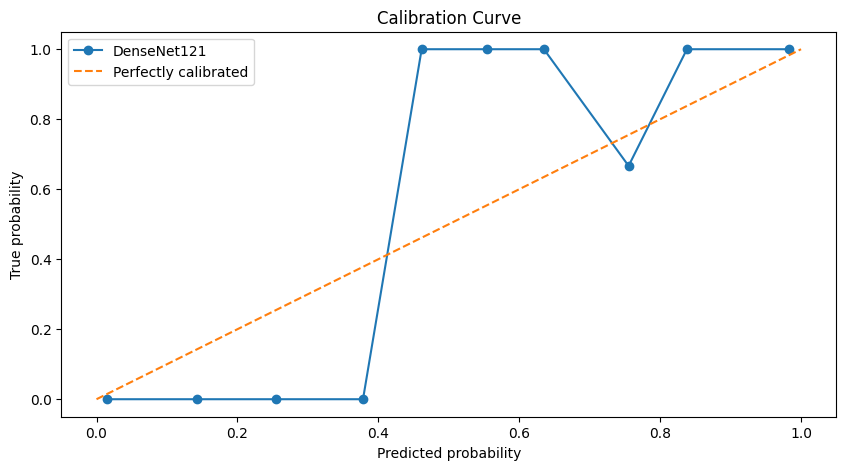

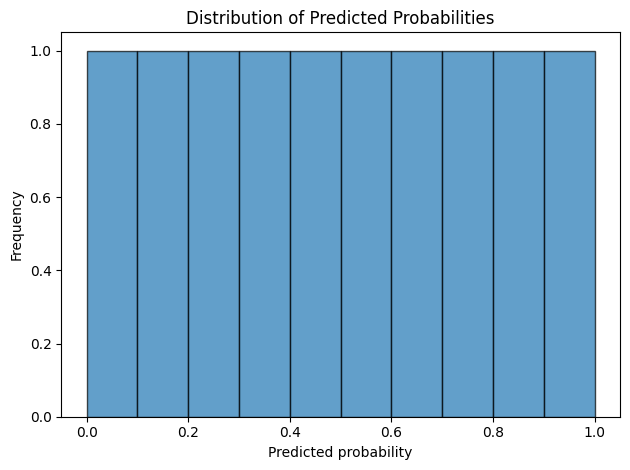

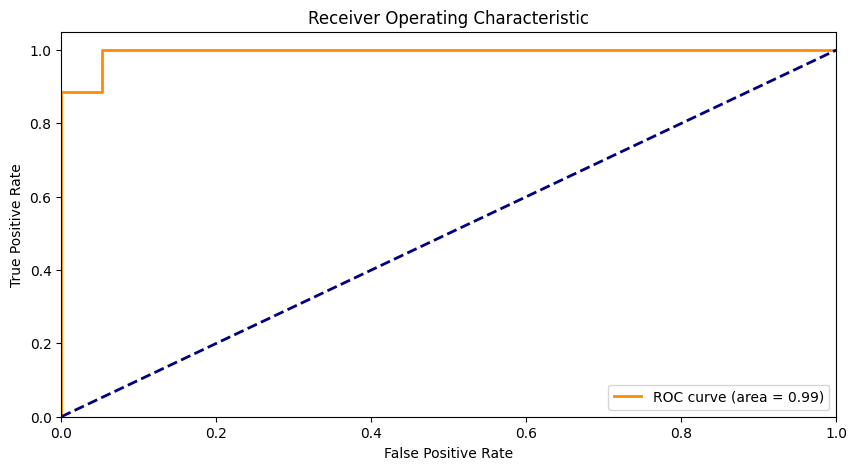

[0.048428252, 0.11100646, 0.007622931, 0.0029819938, 0.26252994, 0.029872138, 0.3782636, 0.74474233, 0.022066405, 0.7372796, 0.0011236324, 0.007422584, 2.8652852e-05, 3.7706755e-05, 0.002625702, 0.0002888071, 0.00016219822, 7.910228e-05, 0.0006437875, 0.00029248808, 0.04189874, 0.21330129, 0.030908622, 0.030908622, 0.0005626984, 0.003089723, 0.044761334, 0.026659863, 0.003089723, 0.28714266, 0.09478545, 0.004831367, 0.0016376857, 0.0016376857, 0.18436125, 0.15456222, 0.0011777859, 0.12335724, 0.7687325, 0.4615012, 0.9979518, 0.9807778, 0.97663933, 0.97071975, 0.98923385, 0.97243845, 0.9365017, 0.99175745, 0.9999869, 0.9979664, 0.8192024, 0.9082248, 0.62705326, 0.8415141, 0.9933543, 0.9899233, 0.7325983, 0.79334474, 0.62142783, 0.5540101, 0.9995571, 0.9146083, 0.9985667, 0.98909444, 0.9849363, 0.9997681, 0.9996153, 0.99991715, 0.997721, 0.9994299, 0.999987, 0.99982625, 0.99996734, 0.9999999, 0.9999969, 0.9999969, 0.9999968, 0.99990046, 0.9384093, 0.9194821, 0.98260766, 0.8533028, 0.9745

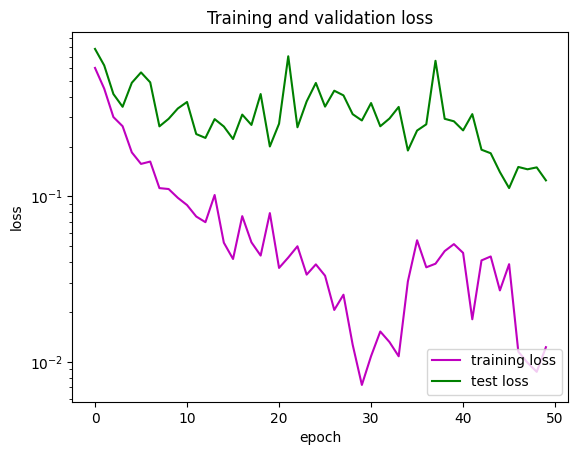

In [5]:
model = DenseNet169(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,
    pretrained=True)
model = model.to(device)
# Hyperparams
threshold = 0.5
output_dim = 1
num_epochs = 50
lr = 5e-5
weight_decay = 1e-3
hyperparams = {'threshold': threshold, 'output_dim': output_dim, 'num_epochs': num_epochs, 'lr': lr, 'weight_decay': weight_decay}

criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, verbose=True,
                                                          threshold=0.01, threshold_mode='abs')

train_losses, test_losses = [], []
accumulation_steps = 3
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    all_train_labels = []
    all_train_preds = []
    steps = 0
    optimiser.zero_grad()


    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        steps += 1
        # Forward pass
        #optimizer.zero_grad()
        output = model(features)  # Remove batch dimension
        output = output.squeeze(1)
        loss = criterion(output, labels.float())
        train_loss += loss.item()

        # # Backward pass and optimization
        # loss.backward()
        # optimizer.step()
        # Backward pass and optimization
        loss.backward()
        if steps % accumulation_steps == 1:
            optimiser.step()
            optimiser.zero_grad()

        # Apply threshold to determine predicted class
        #predicted_probs = F.softmax(output, dim=1)[:, 1]  # Probability of class 1 (positive)
        predicted_probs = torch.sigmoid(output)
        predicted_class = (predicted_probs >= threshold).long()

        # Store predictions and labels
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted_class.cpu().numpy())

    optimiser.step()
    optimiser.zero_grad()
    lr_scheduler.step(train_loss/len(train_loader))
    print('Learning rate:', optimiser.param_groups[0]['lr'])
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_auc = roc_auc_score(all_train_labels, all_train_preds)
    train_confusion_matrix = confusion_matrix(all_train_labels, all_train_preds)
    tn, fp, fn, tp = confusion_matrix(all_train_labels, all_train_preds).ravel()
    # Compute sensitivity (recall) and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    mcc = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Train AUC: {train_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}', f'MCC: {mcc:.4f}')
    print(f'Train Confusion Matrix:')
    print(train_confusion_matrix)
    train_losses.append(train_loss/len(train_loader))

    # Evaluation phase
    model.eval()
    test_loss = 0
    all_test_labels = []
    all_test_preds = []
    all_test_probs = []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            output = model(features)  # Remove batch dimension
            output = output.squeeze(1)
            loss = criterion(output, labels.float())
            test_loss += loss.item()

            # Store predictions and labels
            #predicted_probs = F.softmax(output, dim=1)[:, 1]  # Probability of class 1 (positive)
            predicted_probs = torch.sigmoid(output)
            predicted_class = (predicted_probs >= threshold).type(torch.long)
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(predicted_class.cpu().numpy())
            all_test_probs.extend(predicted_probs.cpu().numpy())

    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    test_auc = roc_auc_score(all_test_labels, all_test_preds)
    test_confusion_matrix = confusion_matrix(all_test_labels, all_test_preds)
    tn, fp, fn, tp = confusion_matrix(all_test_labels, all_test_preds).ravel()
    # Compute sensitivity (recall) and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    mcc = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}', f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}', f'MCC: {mcc:.4f}')
    print('Test Confusion Matrix:')
    print(test_confusion_matrix)
    test_losses.append(test_loss/len(test_loader))

    if epoch == 5 or epoch % 25 == 0 or epoch == num_epochs-1:
        prob_true, prob_pred = calibration_curve(all_test_labels, all_test_probs, n_bins=10)

        plt.figure(figsize=(10, 5))

        # Plot calibration curve
        plt.plot(prob_pred, prob_true, marker='o', label='DenseNet121')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
        plt.xlabel('Predicted probability')
        plt.ylabel('True probability')
        plt.title('Calibration Curve')
        plt.legend()
        plt.show()

        # Plot distribution of predicted probabilities
        plt.hist(prob_pred, bins=10, range=(0, 1), edgecolor='k', alpha=0.7)
        plt.xlabel('Predicted probability')
        plt.ylabel('Frequency')
        plt.title('Distribution of Predicted Probabilities')

        plt.tight_layout()
        plt.show()

        # Plot the roc curve
        fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
print(all_test_probs)
print(hyperparams)

fig, ax1 = plt.subplots()
plt.plot(train_losses, 'm', label = 'training loss')
plt.plot(test_losses, 'g', label = 'test loss')
plt.yscale("log")
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.show()
plt.close()



In [154]:
def error_analysis(probabilities_list, labels):
    # find elementwise average across probabilities
    avg_conf = np.mean(probabilities_list, axis=0)
    print('Average confidence:', avg_conf)
    for i, score in enumerate(avg_conf):
        if (score <= 0.5 and labels[i] == 1) or (score >= 0.5 and labels[i] == 0):
            print(f'Incorrect on average: Index: {i}, label {labels[i]}, Average Confidence: {score}, file: {val_paths[i][0]}')
        elif (0.25 <= score <= 0.75):
            print(f'Unconfident but correct: Index: {i}, label {labels[i]}, Average Confidence: {score}, file: {val_paths[i][0]}')
            
    correct_positive_indices_list, incorrect_positive_indices_list, correct_negative_indices_list, incorrect_negative_indices_list = [], [], [], []

    for i in range(len(probabilities_list)):
        probabilities = probabilities_list[i]
        predictions = np.array([1 if j >= 0.5 else 0 for j in probabilities])

        # Correct positive predictions
        correct_positive_indices = np.where((labels == 1) & (predictions == 1))[0]

        # Incorrect positive predictions
        incorrect_positive_indices = np.where((labels == 0) & (predictions == 1))[0]

        # Confidence of positive predictions
        positive_predictions_probabilities = probabilities[predictions == 1]

        # print('Positive')
        # print('Correct positive indices and confidence:', correct_positive_indices, probabilities[correct_positive_indices])
        # print('Incorrect positive indices and confidence:', incorrect_positive_indices, probabilities[incorrect_positive_indices])

        # Correct positive predictions
        correct_negative_indices = np.where((labels == 0) & (predictions == 0))[0]

        # Incorrect positive predictions
        incorrect_negative_indices = np.where((labels == 1) & (predictions == 0))[0]

        # Confidence of positive predictions
        negative_predictions_probabilities = probabilities[predictions == 0]

        # print('Negative')
        # print('Correct negative indices and confidence:', correct_negative_indices, probabilities[correct_negative_indices])
        # print('Incorrect negative indices and confidence:', incorrect_negative_indices, probabilities[incorrect_negative_indices])

        correct_positive_indices_list.extend(correct_positive_indices)
        incorrect_positive_indices_list.extend(incorrect_positive_indices)
        correct_negative_indices_list.extend(correct_negative_indices)
        incorrect_negative_indices_list.extend(incorrect_negative_indices)

    correct_positive_counter = Counter(correct_positive_indices_list)
    incorrect_positive_counter = Counter(incorrect_positive_indices_list)
    correct_negative_counter = Counter(correct_negative_indices_list)
    incorrect_negative_counter = Counter(incorrect_negative_indices_list)

    average_confidence = np.mean(probabilities_list, axis=0)

    fig, ax = plt.subplots(4, 1, figsize=(12, 16))
    # Correct Positive Predictions
    ax[0].bar(correct_positive_counter.keys(), correct_positive_counter.values(), color='green')
    ax[0].set_title('Frequency of Correct Positive (TP) Predictions Indices Over Multiple Runs')
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xticks(list(correct_positive_counter.keys()))

    # Incorrect Negative Predictions
    ax[1].bar(incorrect_negative_counter.keys(), incorrect_negative_counter.values(), color='red')
    ax[1].set_title('Frequency of Incorrect Negative (FN) Predictions Indices Over Multiple Runs')
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xticks(list(incorrect_negative_counter.keys()))

    # Incorrect Positive Predictions
    ax[2].bar(incorrect_positive_counter.keys(), incorrect_positive_counter.values(), color='red')
    ax[2].set_title('Frequency of Incorrect Positive (FP) Predictions Indices Over Multiple Runs')
    ax[2].set_xlabel('Index')
    ax[2].set_ylabel('Frequency')
    ax[2].set_xticks(list(incorrect_positive_counter.keys()))

    # Correct Negative Predictions
    ax[3].bar(correct_negative_counter.keys(), correct_negative_counter.values(), color='green')
    ax[3].set_title('Frequency of Correct Negative (TN) Predictions Indices Over Multiple Runs')
    ax[3].set_xlabel('Index')
    ax[3].set_ylabel('Frequency')
    ax[3].set_xticks(list(correct_negative_counter.keys()))
    plt.tight_layout()
    plt.show()

In [125]:
#1 DenseNet169 with ground truth masks
# Train Loss: 0.0508, Train Accuracy: 0.9899, Train AUC: 0.9902, Sensitivity: 0.9839, Specificity: 0.9965 MCC: 0.9798
# Train Confusion Matrix:
# [[281   1]
#  [  5 306]]
# Test Loss: 0.2441, Test Accuracy: 0.9231, Test AUC: 0.9302 Sensitivity: 0.8868, Specificity: 0.9737 MCC: 0.8500
# Test Confusion Matrix:
# [[37  1]
#  [ 6 47]]

# 2 DenseNet169 with logit masks
#Train Loss: 0.0680, Train Accuracy: 0.9815, Train AUC: 0.9812, Sensitivity: 0.9871, Specificity: 0.9752 MCC: 0.9628
# Train Confusion Matrix:
# [[275   7]
#  [  4 307]]
# Test Loss: 0.2390, Test Accuracy: 0.9121, Test AUC: 0.9059 Sensitivity: 0.9434, Specificity: 0.8684 MCC: 0.8188
# Test Confusion Matrix:
# [[33  5]
#  [ 3 50]]

# 3 DenseNet169 with multitask logit masks
# Train Loss: 0.0427, Train Accuracy: 0.9916, Train AUC: 0.9915, Sensitivity: 0.9936, Specificity: 0.9894 MCC: 0.9831
# Train Confusion Matrix:
# [[279   3]
#  [  2 309]]
# Test Loss: 0.2281, Test Accuracy: 0.9121, Test AUC: 0.9171 Sensitivity: 0.8868, Specificity: 0.9474 MCC: 0.8252
# Test Confusion Matrix:
# [[36  2]
#  [ 6 47]]

#4  DenseNet169 with multitask binary masks
# Train Loss: 0.0548, Train Accuracy: 0.9865, Train AUC: 0.9863, Sensitivity: 0.9904, Specificity: 0.9823 MCC: 0.9730
# Train Confusion Matrix:
# [[277   5]
#  [  3 308]]
# Test Loss: 0.2374, Test Accuracy: 0.9341, Test AUC: 0.9434 Sensitivity: 0.8868, Specificity: 1.0000 MCC: 0.8751
# Test Confusion Matrix:
# [[38  0]
#  [ 6 47]]

# 5 just image
# Train Loss: 0.0576, Train Accuracy: 0.9882, Train AUC: 0.9882, Sensitivity: 0.9871, Specificity: 0.9894 MCC: 0.9763
# Train Confusion Matrix:
# [[279   3]
#  [  4 307]]
# Test Loss: 0.1092, Test Accuracy: 0.9780, Test AUC: 0.9811 Sensitivity: 0.9623, Specificity: 1.0000 MCC: 0.9561
# Test Confusion Matrix:
# [[38  0]
#  [ 2 51]]

# 6 just image
# Train Loss: 0.0571, Train Accuracy: 0.9865, Train AUC: 0.9860, Sensitivity: 0.9968, Specificity: 0.9752 MCC: 0.9731
# Train Confusion Matrix:
# [[275   7]
#  [  1 310]]
# Test Loss: 0.1488, Test Accuracy: 0.9231, Test AUC: 0.9191 Sensitivity: 0.9434, Specificity: 0.8947 MCC: 0.8415
# Test Confusion Matrix:
# [[34  4]
#  [ 3 50]]

# 7 just image
# {'threshold': 0.5, 'output_dim': 1, 'num_epochs': 25, 'lr': 5e-05, 'weight_decay': 0.001}
# Train Loss: 0.0278, Train Accuracy: 0.9983, Train AUC: 0.9982, Sensitivity: 1.0000, Specificity: 0.9965 MCC: 0.9966
# Train Confusion Matrix:
# [[281   1]
#  [  0 311]]
# Test Loss: 0.0853, Test Accuracy: 0.9670, Test AUC: 0.9717 Sensitivity: 0.9434, Specificity: 1.0000 MCC: 0.9351
# Test Confusion Matrix:
# [[38  0]
#  [ 3 50]]

# just mask on its own 
# Test Accuracy: 0.6703, Test AUC: 0.6909 Sensitivity: 0.5660, Specificity: 0.8158 MCC: 0.3834

labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
probabilities = np.array([[0.057648662, 0.13251266, 0.030323213, 0.7076175, 0.1488829, 0.0029133568, 0.15396164, 0.043485172, 0.0902537, 0.02347875, 0.002472421, 0.003776084, 8.873705e-05, 0.01065515, 0.0020218734, 6.2414874e-05, 0.00077229383, 0.0005571693, 0.009528492, 0.0001969956, 0.012106179, 0.0034497313, 0.005522224, 0.023738058, 0.0020154698, 0.0034760116, 0.0357441, 0.061825495, 0.015583384, 0.09482298, 0.0074583306, 0.010102802, 0.07852834, 0.02021635, 0.035857957, 0.032903638, 0.28978655, 0.1141601, 0.99657226, 0.7939388, 0.7347509, 0.207687, 0.065647274, 0.99797803, 0.9999989, 0.9998721, 0.99271774, 0.6501528, 0.98410195, 0.9992976, 0.96147853, 0.9360526, 0.91196895, 0.87814724, 0.8590348, 0.97082907, 0.55427253, 0.17866428, 0.0823494, 0.027796227, 0.99536276, 0.9879985, 0.9998109, 0.9348579, 0.78386325, 0.9999987, 0.9999379, 0.99997413, 0.9994698, 0.9999999, 0.9999584, 0.9999968, 0.9999887, 0.9999124, 1.0, 0.9999269, 0.99999845, 0.9999994, 0.8845936, 0.9017963, 0.95805544, 0.6485618, 0.9788052, 0.9907527, 0.6780219, 0.8542743, 0.77982974, 0.70782614, 0.9631464, 0.9998436, 0.46281025], # 1
[0.44018522, 0.34349346, 0.8576869, 0.9085308, 0.15639234, 0.9325719, 0.8153716, 0.72126496, 0.45829782, 0.14289816, 0.1594381, 0.017974354, 0.017204808, 0.079142705, 0.16327263, 0.014951811, 0.011670333, 0.0026264575, 0.01356365, 0.016888425, 0.08041812, 0.066002086, 0.05038229, 0.05038229, 0.049053255, 0.054270636, 0.07437491, 0.067341164, 0.054270636, 0.027923262, 0.0041075805, 0.079419, 0.0053619076, 0.0053619076, 0.034874033, 0.102741085, 0.08300638, 0.1353758, 0.95935774, 0.36945152, 0.999655, 0.9959073, 0.8250343, 0.999546, 0.99860173, 0.9980356, 0.99893194, 0.67454696, 0.9912676, 0.99942577, 0.9066518, 0.906097, 0.88286203, 0.9432116, 0.933127, 0.95662344, 0.68359345, 0.7519299, 0.60160434, 0.44652763, 0.99971, 0.9964217, 0.999356, 0.9418481, 0.9774574, 0.9997229, 0.9972211, 0.9904165, 0.99343127, 0.9985077, 0.9998472, 0.99980587, 0.9999801, 0.9999999, 0.9999999, 0.9999999, 0.99999976, 0.99999857, 0.796125, 0.43011743, 0.9376712, 0.6947446, 0.9891558, 0.99718875, 0.8513512, 0.93497, 0.64304125, 0.55093926, 0.9965454, 0.99981827, 0.6492564], # 2 
[0.015826805, 0.07309353, 0.030696075, 0.0049576187, 0.28685787, 0.2750905, 0.03968281, 0.759553, 0.060727462, 0.07857234, 0.007904834, 0.011884623, 0.00025188876, 0.00014870541, 0.00085912563, 0.0030077142, 0.0023761436, 0.00025349934, 0.010753048, 0.0015876876, 0.13420492, 0.32326797, 0.00780785, 0.00780785, 0.0022495738, 0.06791253, 0.0002937375, 0.0007397992, 0.06791253, 0.0008056459, 0.013437897, 0.0011961084, 0.002425761, 0.002425761, 0.0033400133, 0.0053911135, 0.0013700866, 0.6165112, 0.87312055, 0.4728476, 0.9998247, 0.9983841, 0.97383773, 0.99944407, 0.99994195, 0.9995677, 0.9568097, 0.7361591, 0.71860856, 0.99916315, 0.9029098, 0.9528623, 0.88440144, 0.9002828, 0.95874244, 0.87183535, 0.14464891, 0.47491103, 0.13261083, 0.2148327, 0.9927269, 0.5907132, 0.99854064, 0.95161176, 0.9504121, 0.9985417, 0.9987866, 0.99673104, 0.8782047, 0.9995202, 0.99980456, 0.9990483, 0.9994455, 0.9999907, 0.9999819, 0.9999819, 0.9999889, 0.9999914, 0.7979214, 0.9540534, 0.9831086, 0.93588024, 0.9673767, 0.99289024, 0.91958976, 0.89585704, 0.84134793, 0.9243081, 0.9880683, 0.99964917, 0.22156657], #3
[0.008535521, 0.040429838, 0.0013002328, 0.0029006412, 0.099630505, 0.005676224, 0.015113053, 0.05915319, 0.077868365, 0.018408217, 0.010920803, 0.011437823, 0.003192917, 0.0003163443, 0.0018702524, 0.0015455952, 0.020717641, 0.00022538623, 0.031040668, 0.008252196, 0.016045151, 0.010188192, 0.0069710137, 0.0069710137, 0.006670982, 0.0027516505, 0.008174712, 0.001099582, 0.0027516505, 0.008664685, 0.0026675595, 0.0019587872, 0.0021042007, 0.0021042007, 0.0038366658, 0.0011121633, 0.0001067919, 0.012161266, 0.986906, 0.45633018, 1.0, 1.0, 0.9998425, 1.0, 1.0, 0.99999833, 0.9869496, 0.023280093, 0.19532341, 0.9890021, 0.6230195, 0.98229593, 0.37799075, 0.92165846, 0.93812, 0.9941506, 0.4721434, 0.6783353, 0.8831638, 0.73913443, 0.9999714, 0.6267879, 0.9999975, 0.9674667, 0.8530862, 0.99999964, 0.9999937, 0.99998796, 0.99999297, 0.9999999, 1.0, 0.9999999, 0.9999995, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9364626, 0.6906867, 0.98100203, 0.63807505, 0.9844967, 0.9964986, 0.94705105, 0.9068745, 0.8494458, 0.8452797, 0.97664136, 0.9999088, 0.12142306], #4
 [0.08833644, 0.1633069, 0.025506161, 0.0045498204, 0.021559672, 0.007455003, 0.018239005, 0.0023367219, 0.080203, 0.12379198, 0.0076961424, 0.006612611, 0.0012851965, 0.00021506361, 0.0074763414, 0.0038890496, 0.0030335188, 4.787776e-05, 0.008320192, 0.01583937, 0.09894133, 0.21821557, 5.5139782e-05, 5.5139782e-05, 0.044390604, 0.0008392312, 0.000108729226, 0.0007067763, 0.0008392312, 2.9599601e-05, 5.0143153e-05, 3.5101966e-05, 2.101268e-06, 2.101268e-06, 0.00021730353, 1.6873875e-05, 5.4045864e-07, 0.0009501681, 0.8990985, 0.82269245, 0.9815828, 0.97364503, 0.98873645, 0.9757304, 0.9881011, 0.97683185, 0.76442957, 0.9848683, 0.9912163, 0.9743009, 0.7471334, 0.7871165, 0.8191089, 0.75972515, 0.8448576, 0.7968252, 0.41108596, 0.2884309, 0.751458, 0.53302217, 0.999944, 0.953689, 0.9998572, 0.98886, 0.9797987, 0.99999976, 0.9999994, 1.0, 0.9999093, 0.9999994, 0.9999907, 0.9999975, 0.99999917, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9245396, 0.5684722, 0.73782796, 0.94898605, 0.8799265, 0.9968876, 0.8158101, 0.958319, 0.89719164, 0.8986541, 0.91331047, 0.9632082, 0.62238467], #5
[0.5410697, 0.9635723, 0.09101596, 0.025810938, 0.1329012, 0.25460988, 0.19122653, 0.03277724, 0.030101227, 0.061826196, 0.010662682, 0.0297179, 0.0014596017, 0.00011124033, 0.0025107383, 0.004103334, 0.0022227627, 8.893985e-05, 0.012162554, 0.0019515742, 0.5647942, 0.59159184, 0.0008679404, 0.0008679404, 0.038758725, 0.0012299956, 0.0012363537, 0.0023217914, 0.0012299956, 0.00040102281, 0.0014645467, 0.0012004263, 8.436208e-05, 8.436208e-05, 0.0018652563, 0.00022335011, 2.9936678e-05, 0.00041136274, 0.91033906, 0.9054641, 0.99838495, 0.9994967, 0.9995517, 0.9992142, 0.99993694, 0.99528813, 0.8889745, 0.63720757, 0.9743066, 0.982434, 0.67467034, 0.7645924, 0.7123568, 0.7514132, 0.93466604, 0.8703946, 0.4497924, 0.366571, 0.748451, 0.6004479, 0.9997758, 0.94413954, 0.99805546, 0.9954397, 0.9747141, 0.99999964, 1.0, 1.0, 0.999881, 0.9999993, 0.9999846, 0.9999877, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 1.0, 1.0, 0.9700754, 0.41099015, 0.89514023, 0.8790551, 0.9686384, 0.9969121, 0.9890531, 0.977616, 0.92049146, 0.91338795, 0.9723456, 0.99677974, 0.8406587], #6
[0.40011355, 0.03681427, 0.015130686, 0.013662592, 0.04261297, 0.01064131, 0.06937232, 0.008099831, 0.0018533823, 0.26047954, 0.003050914, 0.010877135, 0.00021711981, 2.026713e-05, 0.0007700942, 0.0030872212, 0.007001325, 9.2680944e-05, 0.006529842, 0.0022168297, 0.09433989, 0.05927431, 0.0069628223, 0.0069628223, 0.020522272, 0.00014754906, 0.00016768696, 0.00046992654, 0.00014754906, 5.1534276e-05, 3.8499e-05, 1.7650666e-05, 8.148881e-06, 8.148881e-06, 5.1295796e-05, 0.00011631985, 2.0187848e-05, 0.0012188293, 0.96294755, 0.83474565, 0.9994097, 0.971106, 0.7606563, 0.9924035, 0.9978321, 0.98850024, 0.9013579, 0.99995863, 0.99999785, 0.999928, 0.9609384, 0.9744878, 0.9908461, 0.99532396, 0.9992273, 0.9990382, 0.87288815, 0.2688335, 0.9875159, 0.9030145, 0.99985754, 0.99237, 0.9998901, 0.99962294, 0.9986162, 1.0, 1.0, 1.0, 0.99999976, 1.0, 0.99997485, 0.9999734, 0.99999535, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9083636, 0.398549, 0.94322973, 0.2534013, 0.9799913, 0.99998665, 0.997618, 0.99811184, 0.7334117, 0.9442052, 0.9985637, 0.9969687, 0.7098364], #7          
        ])


Average confidence: [1.91933725e-01 2.86068115e-01 1.72754757e-01 2.75727886e-01
 1.41037414e-01 2.46386144e-01 2.05599106e-01 2.69761714e-01
 1.32908596e-01 7.48292738e-02 3.31824971e-02 1.35672325e-02
 3.91385817e-03 1.50982014e-02 2.96684935e-02 4.59331981e-03
 6.79878215e-03 6.33221663e-04 1.42281007e-02 7.45270807e-03
 1.51084983e-01 2.02119232e-01 1.19344096e-02 1.49703820e-02
 2.38564349e-02 2.17466758e-02 1.99887571e-02 2.23391013e-02
 2.37645712e-02 2.21078659e-02 4.86434291e-03 1.56520376e-02
 1.47511121e-02 5.03244711e-03 1.33318715e-02 2.37313706e-02
 6.23833809e-02 1.46594983e-01 9.37565685e-01 6.36787442e-01
 9.52366392e-01 8.62520022e-01 8.08774992e-01 9.95318783e-01
 9.97763437e-01 9.94932285e-01 9.31468842e-01 6.17702470e-01
 8.09137403e-01 9.90603920e-01 8.02643895e-01 8.88169455e-01
 7.64781478e-01 8.59073075e-01 9.11424647e-01 9.10109710e-01
 4.52589442e-01 4.56473735e-01 5.33272895e-01 4.26960176e-01
 9.97915143e-01 8.49958307e-01 9.99269617e-01 9.63347360e-01
 9.1

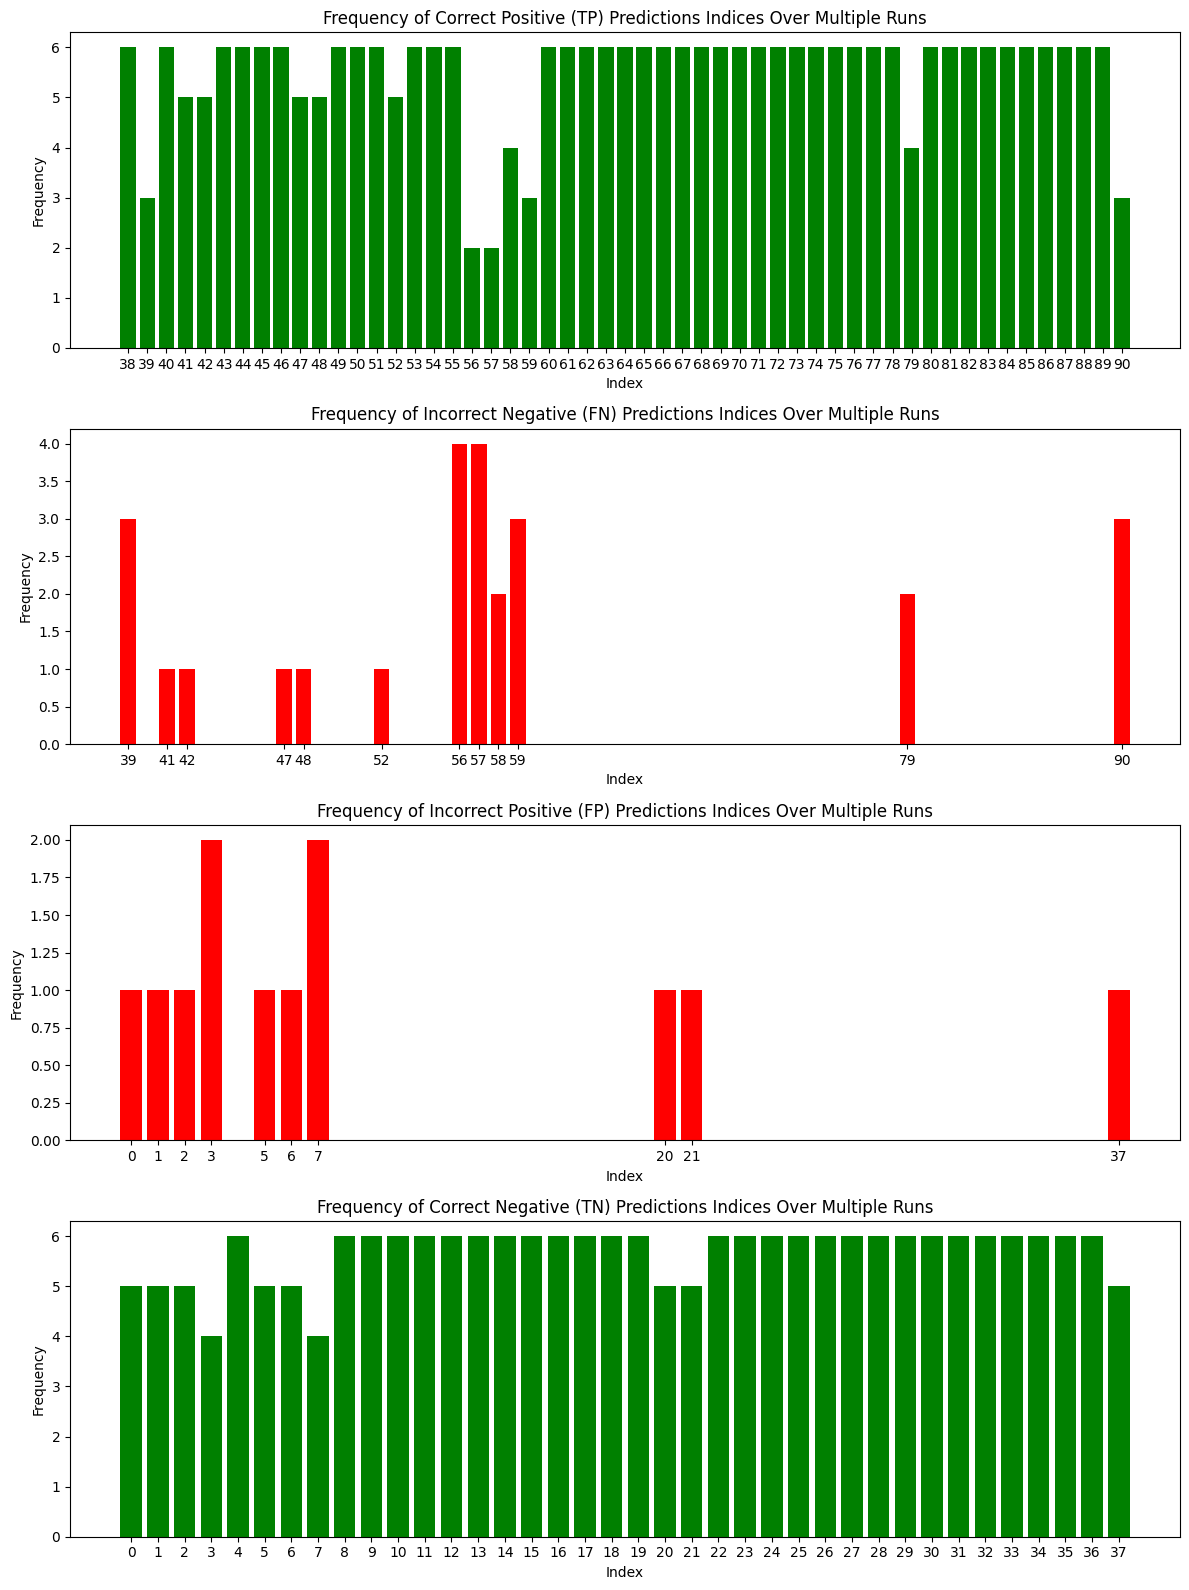

In [126]:
error_analysis(probabilities, labels)

In [115]:
val_paths[56]

['C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/validation_dataset\\FM\\FM34_1.jpg',
 'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/multitask/binary postprocessed/multitask_postproc_validation\\FM\\FM34_1_mask.tif']

In [ ]:
FPs = [BM12_4, BM12_8]
FNs = [FM34_4, FM34_2, FM34_3, FM104_2, FM9_3]

